## Getting the data

## Import Tools

In [1]:
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import io
import torch
import torch.nn as nn
from torchinfo import summary
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.auto import tqdm
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Preprocessing

In [2]:
# !unzip "tpu-getting-started.zip"

In [3]:
ROOT= "/kaggle/input/tpu-getting-started/"
train_files = glob.glob(ROOT + 'tfrecords-jpeg-192x192/train/*.tfrec')# + glob.glob('tfrecords-jpeg-224x224/train/*.tfrec') + glob.glob('tfrecords-jpeg-331x331/train/*.tfrec') + glob.glob('tfrecords-jpeg-512x512/train/*.tfrec')
val_files = glob.glob(ROOT + 'tfrecords-jpeg-192x192/val/*.tfrec')# + glob.glob('tfrecords-jpeg-224x224/val/*.tfrec') + glob.glob('tfrecords-jpeg-331x331/val/*.tfrec') + glob.glob('tfrecords-jpeg-512x512/val/*.tfrec')
test_files = glob.glob(ROOT + 'tfrecords-jpeg-192x192/test/*.tfrec')# + glob.glob('tfrecords-jpeg-224x224/test/*.tfrec') + glob.glob('tfrecords-jpeg-331x331/test/*.tfrec') + glob.glob('tfrecords-jpeg-512x512/test/*.tfrec')


In [4]:
len(train_files), len(val_files), len(test_files)

(16, 16, 16)

In [5]:
train_files[:5]

['/kaggle/input/tpu-getting-started/tfrecords-jpeg-192x192/train/06-192x192-798.tfrec',
 '/kaggle/input/tpu-getting-started/tfrecords-jpeg-192x192/train/11-192x192-798.tfrec',
 '/kaggle/input/tpu-getting-started/tfrecords-jpeg-192x192/train/12-192x192-798.tfrec',
 '/kaggle/input/tpu-getting-started/tfrecords-jpeg-192x192/train/03-192x192-798.tfrec',
 '/kaggle/input/tpu-getting-started/tfrecords-jpeg-192x192/train/09-192x192-798.tfrec']

In [6]:
FLOWER_NAMES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']

In [7]:
device = 'cuda'

### Turn TFRecord into a usable files
https://medium.com/analytics-vidhya/how-to-read-tfrecords-files-in-pytorch-72763786743f

#### Train

In [8]:
train_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  return tf.io.parse_single_example(example_proto, train_feature_description)

train_ids = []
train_class = []
train_images = []

for i in train_files:
  train_image_dataset = tf.data.TFRecordDataset(i)

  train_image_dataset = train_image_dataset.map(_parse_image_function)

  ids = [str(id_features['id'].numpy())[2:-1] for id_features in train_image_dataset] # [2:-1] is done to remove b' from 1st and 'from last in train id names
  train_ids = train_ids + ids

  classes = [int(class_features['class'].numpy()) for class_features in train_image_dataset]
  train_class = train_class + classes

  images = [image_features['image'].numpy() for image_features in train_image_dataset]
  train_images = train_images + images

#### Valid

In [9]:
val_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, val_feature_description)

val_ids = []
val_class = []
val_images = []

for i in val_files:
    val_image_dataset = tf.data.TFRecordDataset(i)

    val_image_dataset = val_image_dataset.map(_parse_image_function)

    ids = [str(image_features['id'].numpy())[2:-1] for image_features in val_image_dataset]
    val_ids += ids

    classes = [int(image_features['class'].numpy()) for image_features in val_image_dataset]
    val_class += classes

    images = [image_features['image'].numpy() for image_features in val_image_dataset]
    val_images += images

#### Test

In [10]:
test_feature_description = {
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function_test(example_proto):
    return tf.io.parse_single_example(example_proto, test_feature_description)

test_ids = []
test_images = []
for i in test_files:
    test_image_dataset = tf.data.TFRecordDataset(i)

    test_image_dataset = test_image_dataset.map(_parse_image_function_test)

    ids = [str(id_features['id'].numpy())[2:-1] for id_features in test_image_dataset]
    test_ids = test_ids + ids

    images = [image_features['image'].numpy() for image_features in test_image_dataset]
    test_images = test_images + images

### Usable File -> Dataset -> DataLoader

#### Custom dataset

In [11]:
class ParsedImageDataset:
  def __init__(self, ids, labels, images, transforms=None, is_test=False):
    self.ids = ids
    self.labels = labels
    self.transforms = transforms
    self.images = images
    self.is_test = is_test

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, idx):
      img = self.images[idx]
      img = Image.open(io.BytesIO(img))

      if self.transforms:
        img = self.transforms(img)

      if self.is_test:
        return img, -1, self.ids[idx]
      return img, int(self.labels[idx]), self.ids[idx]



In [12]:
train_transforms = transforms.Compose([
                        transforms.RandomResizedCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        # transforms.RandomErasing()
                    ])

test_transforms = transforms.Compose([
                        transforms.CenterCrop(224),
                        transforms.Resize(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

#### Train Data Loader

In [13]:
train_dataset = ParsedImageDataset(ids=train_ids, labels=train_class, images=train_images, transforms=train_transforms)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, num_workers=2)

In [14]:
len(train_dataset), len(train_loader)

(12753, 200)

#### Valid Data Loader

In [15]:
valid_dataset = ParsedImageDataset(ids=val_ids, labels=val_class, images=val_images, transforms=test_transforms)
valid_loader = DataLoader(dataset=train_dataset, batch_size=64, num_workers=2)

In [16]:
len(valid_dataset), len(valid_loader)

(3712, 200)

#### Test Data Loader

In [17]:
test_dataset = ParsedImageDataset(ids=test_ids, labels=-1, images=test_images, transforms=test_transforms, is_test=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, num_workers=2)

In [18]:
len(test_dataset), len(test_loader)

(7382, 116)

### Visualize the preprocessed data


In [19]:
def denormalize_image(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std[:, None, None] + mean[:, None, None]
    image = np.clip(image, 0, 1)
    return image


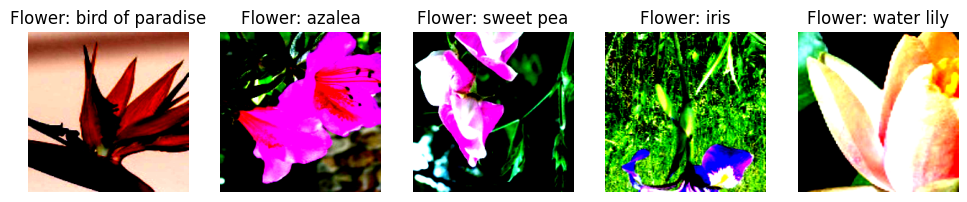

In [20]:
def show_images(dataset, num_images=5, denormalize=False):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        image, label, _ = dataset[i]
        if denormalize:
          image = denormalize_image(image)
        image = image.numpy().transpose((1, 2, 0))
        plt.imshow(image)
        plt.title(f"Flower: {FLOWER_NAMES[label]}")
        plt.axis('off')

    plt.show()


show_images(train_dataset, denormalize=False)

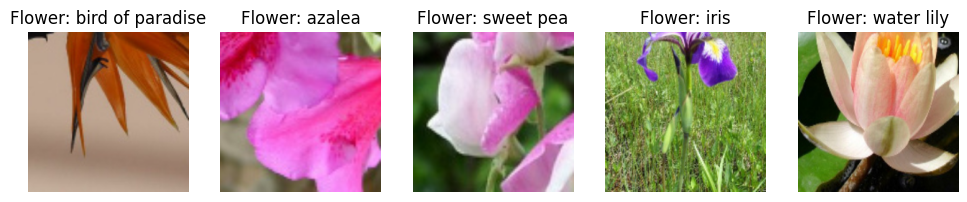

In [21]:
show_images(train_dataset, denormalize=True)

## Getting the model

In [22]:
model = models.squeezenet1_1(pretrained=True)
summary(model=model,
        input_size=(64, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10,
        row_settings=["var_names"])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 104MB/s]


Layer (type (var_name))                       Input Shape Output Shape Param #    Trainable
SqueezeNet (SqueezeNet)                       [64, 3, 224, 224] [64, 1000] --         True
├─Sequential (features)                       [64, 3, 224, 224] [64, 512, 13, 13] --         True
│    └─Conv2d (0)                             [64, 3, 224, 224] [64, 64, 111, 111] 1,792      True
│    └─ReLU (1)                               [64, 64, 111, 111] [64, 64, 111, 111] --         --
│    └─MaxPool2d (2)                          [64, 64, 111, 111] [64, 64, 55, 55] --         --
│    └─Fire (3)                               [64, 64, 55, 55] [64, 128, 55, 55] --         True
│    │    └─Conv2d (squeeze)                  [64, 64, 55, 55] [64, 16, 55, 55] 1,040      True
│    │    └─ReLU (squeeze_activation)         [64, 16, 55, 55] [64, 16, 55, 55] --         --
│    │    └─Conv2d (expand1x1)                [64, 16, 55, 55] [64, 64, 55, 55] 1,088      True
│    │    └─ReLU (expand1x1_activation)    

### Freeze the layers

When to Freeze the Layers?

- Limited Data: If you have a small dataset, it's often beneficial to freeze the layers of the pre-trained model. This prevents overfitting, as only the final layers are trained to adapt to your specific task.
- Similar Domain: If your task is similar to the one the model was originally trained on (e.g., general image classification), the pre-existing weights are likely already quite effective.


In [23]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

num_output_classes = len(FLOWER_NAMES)

model.classifier[1] = nn.Conv2d(512, num_output_classes, kernel_size=(1,1))

model.num_classes = num_output_classes

Check the layer again.

In [24]:
summary(model=model,
        input_size=(64, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape Output Shape Param #    Trainable
SqueezeNet (SqueezeNet)                       [64, 3, 224, 224] [64, 104]  --         Partial
├─Sequential (features)                       [64, 3, 224, 224] [64, 512, 13, 13] --         False
│    └─Conv2d (0)                             [64, 3, 224, 224] [64, 64, 111, 111] (1,792)    False
│    └─ReLU (1)                               [64, 64, 111, 111] [64, 64, 111, 111] --         --
│    └─MaxPool2d (2)                          [64, 64, 111, 111] [64, 64, 55, 55] --         --
│    └─Fire (3)                               [64, 64, 55, 55] [64, 128, 55, 55] --         False
│    │    └─Conv2d (squeeze)                  [64, 64, 55, 55] [64, 16, 55, 55] (1,040)    False
│    │    └─ReLU (squeeze_activation)         [64, 16, 55, 55] [64, 16, 55, 55] --         --
│    │    └─Conv2d (expand1x1)                [64, 16, 55, 55] [64, 64, 55, 55] (1,088)    False
│    │    └─ReLU (expand1x1_activat

## Train the model

### Define Accuracy

In [25]:
def accuracy_step(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### Define Loss Function

In [26]:
loss_fn = torch.nn.CrossEntropyLoss()

### Define Optimizer

In [27]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

### Define Train One Epoch

In [28]:
training_loss_count, validation_loss_count  = [], []

def train_one_epoch(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_step,
               device: torch.device = device):

    train_loss, train_acc = 0, 0
    model.to(device)

    for img, label, _id in data_loader:
      img, label = img.to(device), label.to(device)
      # Forward
      y_pred = model(img)

      # Calculate loss
      loss = loss_fn(y_pred, label)
      train_loss += loss
      train_acc += accuracy_step(y_pred=y_pred.argmax(dim=1), y_true=label)

      # Zero grad
      model.zero_grad()

      # Backward
      loss.backward()

      # Optimizer Step
      optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    training_loss_count.append(train_loss.cpu().item()) # .item() for convert tensor -> python dtypes
    print(f"Done one epoch, Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")


### Define validation one epoch

In [29]:
def validation_one_epoch(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_step,
               device: torch.device = device):
    valid_loss, valid_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
      for img, label, _id in data_loader:
        img, label = img.to(device), label.to(device)
        y_pred = model(img)
        loss = loss_fn(y_pred, label)
        valid_loss += loss
        valid_acc += accuracy_step(y_pred=y_pred.argmax(dim=1), y_true=label)

      valid_loss /= len(data_loader)
      valid_acc /= len(data_loader)
      validation_loss_count.append(valid_loss.cpu().item()) # .item() for convert tensor -> python dtypes
      print(f"Done validation one epoc, Valid Loss: {valid_loss}, Valid accuracy: {valid_acc}")

### Training Loop

In [30]:
EPOCHS = 300

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    train_one_epoch(data_loader=train_loader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_step=accuracy_step,
        device=device)

    validation_one_epoch(data_loader=valid_loader,
        model=model,
        loss_fn=loss_fn,
        accuracy_step=accuracy_step,
        device=device)


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0
---------
Done one epoch, Train loss: 4.3738, Train accuracy: 9.0630
Done validation one epoc, Valid Loss: 3.8885884284973145, Valid accuracy: 17.33639705882353
Epoch: 1
---------
Done one epoch, Train loss: 3.6289, Train accuracy: 21.9127
Done validation one epoc, Valid Loss: 3.3908042907714844, Valid accuracy: 26.547334558823533
Epoch: 2
---------
Done one epoch, Train loss: 3.2383, Train accuracy: 29.5083
Done validation one epoc, Valid Loss: 3.076470375061035, Valid accuracy: 32.26424632352941
Epoch: 3
---------
Done one epoch, Train loss: 2.9598, Train accuracy: 34.3249
Done validation one epoc, Valid Loss: 2.8244035243988037, Valid accuracy: 36.80928308823529
Epoch: 4
---------
Done one epoch, Train loss: 2.7396, Train accuracy: 38.0593
Done validation one epoc, Valid Loss: 2.624972105026245, Valid accuracy: 40.567555147058826
Epoch: 5
---------
Done one epoch, Train loss: 2.5577, Train accuracy: 41.7335
Done validation one epoc, Valid Loss: 2.467261791229248, Valid accu

### Training Visualization

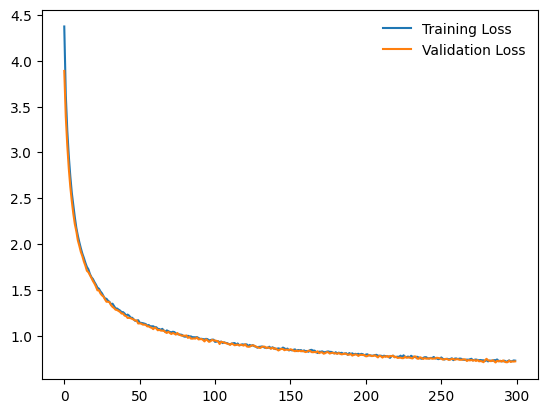

In [31]:
plt.plot(training_loss_count, label='Training Loss')
plt.plot(validation_loss_count, label='Validation Loss')
plt.legend(frameon=False)

In [32]:
submission_data = []

with torch.inference_mode():
    for img, _, _id in test_loader:
        img = img.to(device)
        y_preds = model(img)
        y_preds = y_preds.argmax(dim=1)
        for img_id, y_pred in zip(_id, y_preds.cpu()):
            submission_data.append({'id': img_id, 'label': y_pred.item()})

In [33]:
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv('submission.csv', index=False)